In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colormaps
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import pyart
from pyart.testing import get_test_data
import random
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Define Output Directory
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/Radar_Meteo/HW3/'

In [3]:
# Question 1

In [4]:
# Open File
File = get_test_data('110635.mdv')
Radar = pyart.io.read(File)
Radar

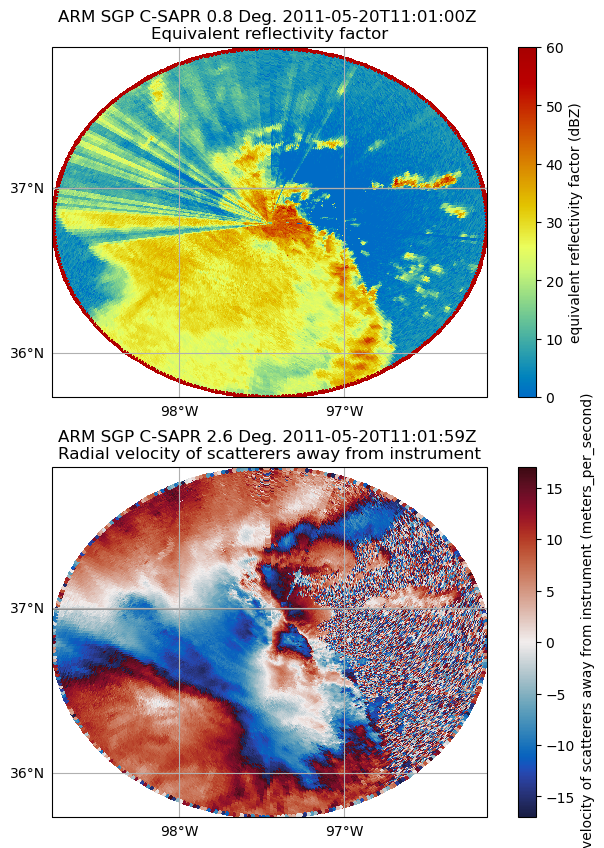

In [5]:
# Plot Reflectivity
Fig = pyplot.figure(figsize=[8,10])
Ax1 = pyplot.subplot(2,1,1, projection=ccrs.PlateCarree())
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('reflectivity', ax=Ax1, sweep=0, resolution='50m', vmin=0, vmax=60, \
projection=ccrs.PlateCarree(), cmap='pyart_HomeyerRainbow')
#
# Plot Velocity
Ax2 = pyplot.subplot(2,1,2, projection=ccrs.PlateCarree())
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('velocity', ax=Ax2, sweep=3, vmin=-17, vmax=17, \
projection=ccrs.PlateCarree(), cmap='pyart_balance')
#
# Savefig
Fig.savefig(Output_Diri+'Q1.1.png', bbox_inches='tight')
pyplot.show()

In [6]:
# Find Nyquist Velocity
Nyquist_Value = Radar.instrument_parameters["nyquist_velocity"]["data"][0]
Nyquist_Value

16.52468

In [7]:
# Calculate Velocity Texture
Vel_Texture = pyart.retrieve.calculate_velocity_texture(Radar, vel_field='velocity', nyq=Nyquist_Value)
Radar.add_field('texture', Vel_Texture, replace_existing=True)
Vel_Texture

{'units': 'meters_per_second',
 'standard_name': 'texture_of_radial_velocity_of_scatters_away_from_instrument',
 'long_name': 'Doppler velocity texture',
 'coordinates': 'elevation azimuth range',
 'data': array([[6.69862024, 6.03811779, 5.67650537, ..., 5.84680145, 5.87766469,
         5.8796826 ],
        [6.69862024, 6.0757411 , 5.67650537, ..., 5.84680145, 5.87766469,
         5.8796826 ],
        [6.72440409, 6.0757411 , 5.67650537, ..., 5.94545992, 5.98767892,
         5.99355426],
        ...,
        [7.58128365, 7.43990786, 6.62367925, ..., 5.69339285, 5.64166993,
         5.64166993],
        [8.30812789, 8.30812789, 6.1530007 , ..., 5.48500863, 5.42860475,
         5.42860475],
        [8.39500845, 8.39500845, 5.96648377, ..., 2.32524392, 2.33743921,
         2.3474649 ]])}

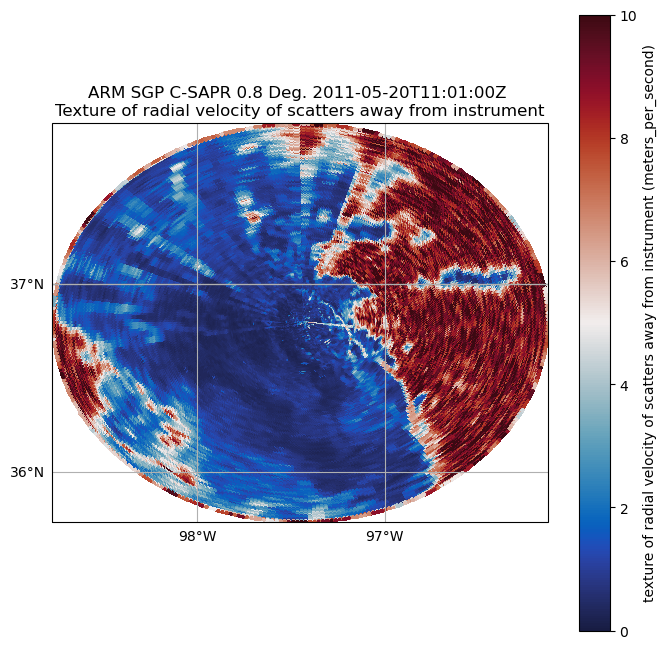

In [8]:
# Plot Velocity Texture Field
Fig = pyplot.figure(figsize=[8,8])
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('texture', sweep=0, resolution='50m', vmin=0, vmax=10, \
projection=ccrs.PlateCarree(), cmap='pyart_balance')
#
# Savefig
Fig.savefig(Output_Diri+'Q1.2.png', bbox_inches='tight')
pyplot.show()

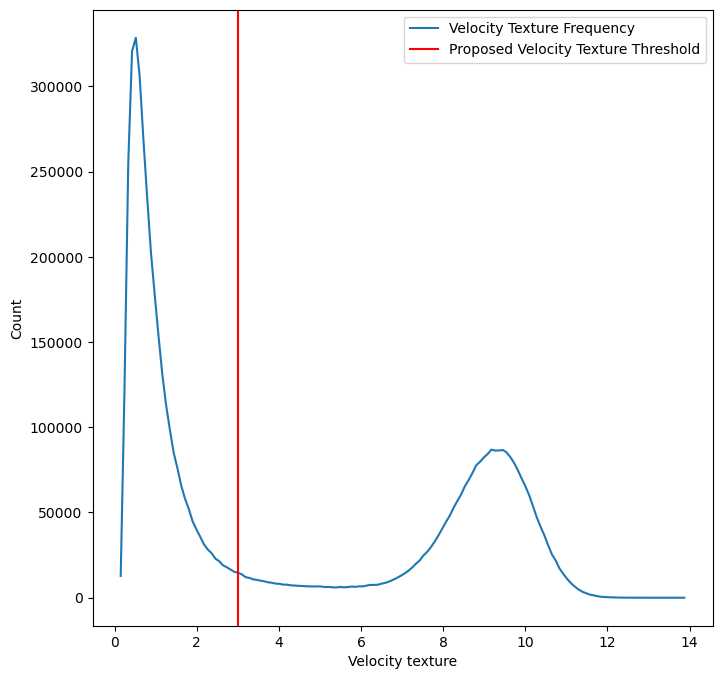

In [9]:
# Determine Velocity Texture Threshold
Fig = pyplot.figure(figsize=[8,8])
Hist, Bins = numpy.histogram(Radar.fields['texture']['data'], bins=150)
Bins = (Bins[1:]+Bins[:-1])/2.0
pyplot.plot(Bins, Hist, label='Velocity Texture Frequency')
pyplot.axvline(3, color='r', label='Proposed Velocity Texture Threshold')
pyplot.xlabel('Velocity texture')
pyplot.ylabel('Count')
pyplot.legend()
Fig.savefig(Output_Diri+'Q1.3.png', bbox_inches='tight')

In [10]:
# Apply Threshold
Gatefilter = pyart.filters.GateFilter(Radar)
Gatefilter.exclude_above('texture', 3)

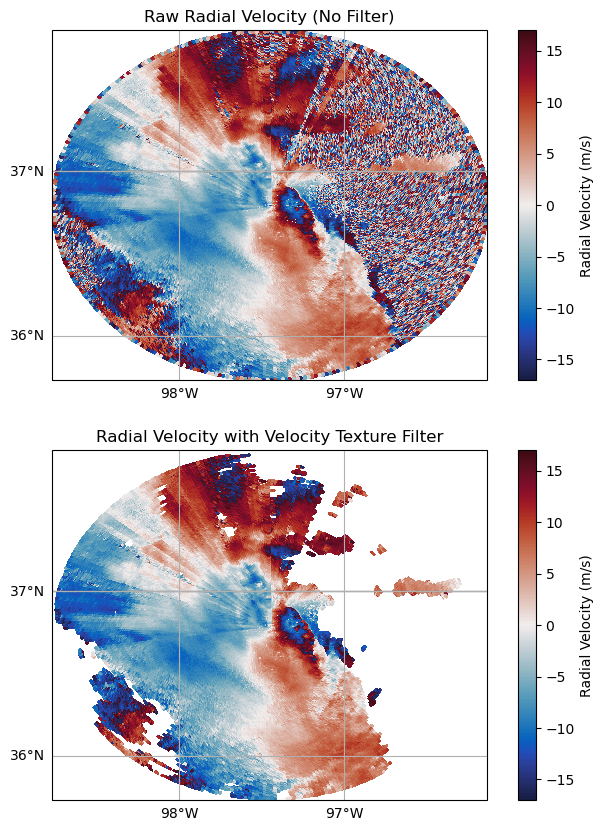

In [11]:
# Plot Unfiltered Data
Fig = pyplot.figure(figsize=[8,10])
Ax1 = pyplot.subplot(2,1,1, projection=ccrs.PlateCarree())
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('velocity', title='Raw Radial Velocity (No Filter)', \
ax=Ax1, sweep=0, resolution='50m', vmin=-17, vmax=17, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Plot Filtered Data
Ax2 = pyplot.subplot(2,1,2, projection=ccrs.PlateCarree())
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('velocity', title='Radial Velocity with Velocity Texture Filter', gatefilter=Gatefilter, \
ax=Ax2, sweep=0, resolution='50m', vmin=-17, vmax=17, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Savefig
Fig.savefig(Output_Diri+'Q1.4.png', bbox_inches='tight')
pyplot.show()

In [12]:
# Dealiasing Velocities
Velocity_Dealiased = pyart.correct.dealias_region_based(Radar, vel_field='velocity', nyquist_vel=Nyquist_Value,
centered=True, gatefilter=Gatefilter)
Radar.add_field('corrected_velocity', Velocity_Dealiased, replace_existing=True)

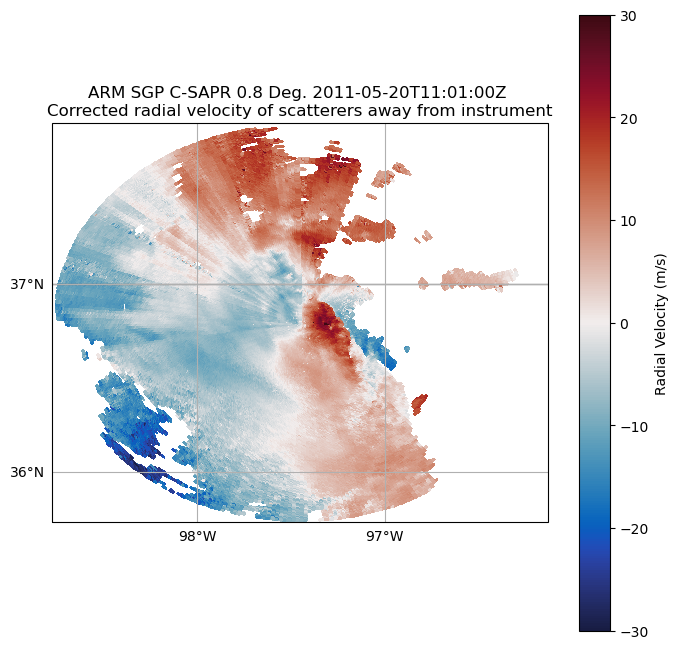

In [13]:
# Plot Dealiased Velocities
Fig = pyplot.figure(figsize=[8,8])
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('corrected_velocity', gatefilter=Gatefilter, sweep=0, resolution='50m', vmin=-30, vmax=30, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Savefig
Fig.savefig(Output_Diri+'Q1.5.png', bbox_inches='tight')
pyplot.show()

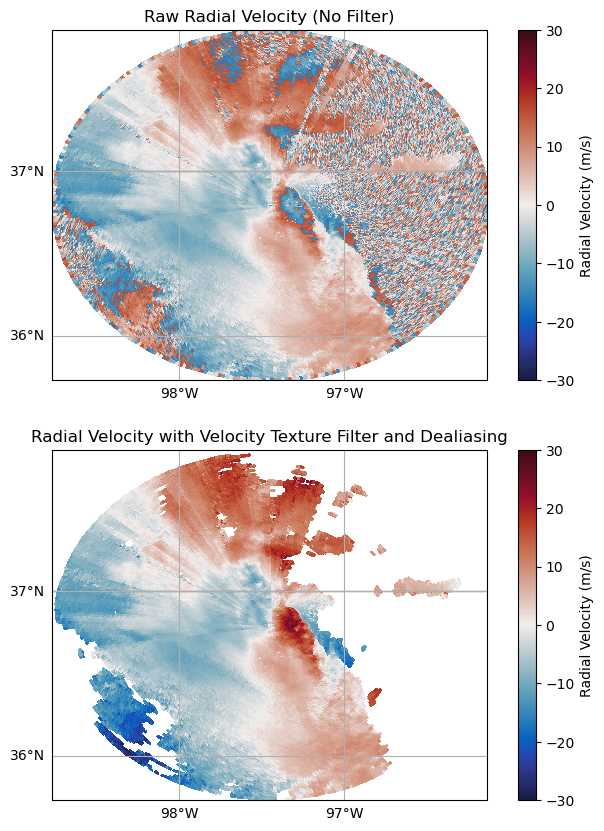

In [14]:
# Plot Unfiltered Data
Fig = pyplot.figure(figsize=[8,10])
Ax1 = pyplot.subplot(2,1,1, projection=ccrs.PlateCarree())
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('velocity', title='Raw Radial Velocity (No Filter)', \
ax=Ax1, sweep=0, resolution='50m', vmin=-30, vmax=30, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Plot Filtered, Dealiased Data
Ax2 = pyplot.subplot(2,1,2, projection=ccrs.PlateCarree())
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('corrected_velocity', title='Radial Velocity with Velocity Texture Filter and Dealiasing', \
gatefilter=Gatefilter, ax=Ax2, sweep=0, resolution='50m', vmin=-30, vmax=30, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Savefig
Fig.savefig(Output_Diri+'Q1.6.png', bbox_inches='tight')
pyplot.show()

In [15]:
# Question 2

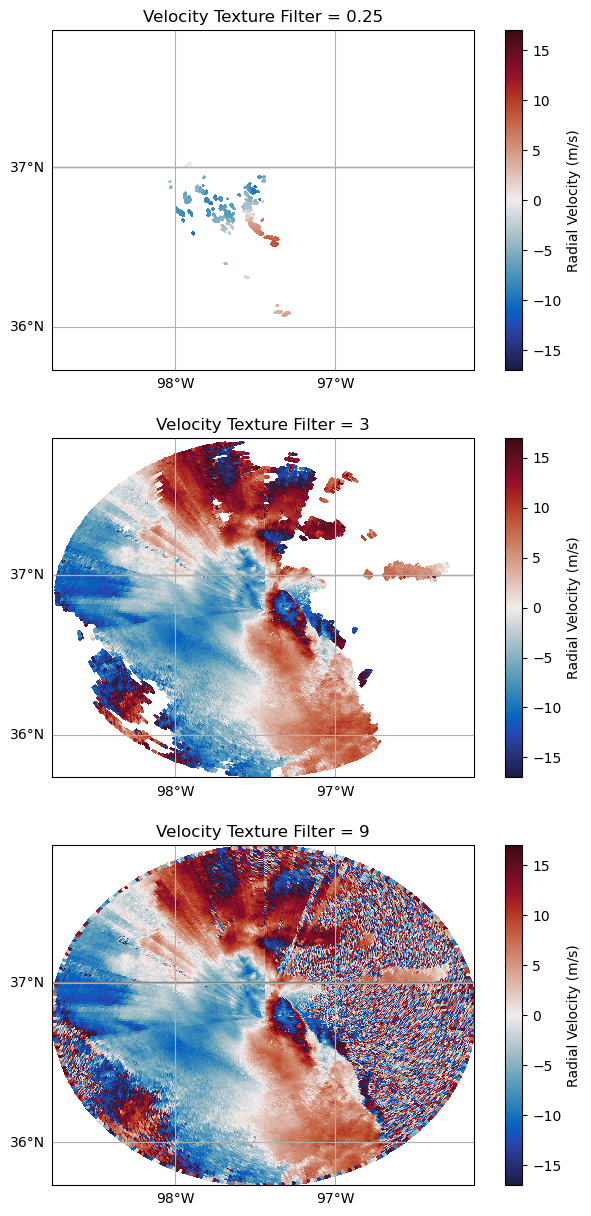

In [16]:
# Texture Value = 0.25
Fig = pyplot.figure(figsize=[8,15])
Ax1 = pyplot.subplot(3,1,1, projection=ccrs.PlateCarree())
Gatefilter = pyart.filters.GateFilter(Radar)
Gatefilter.exclude_above('texture', 0.25)
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('velocity', title='Velocity Texture Filter = 0.25', gatefilter=Gatefilter, \
ax=Ax1, sweep=0, resolution='50m', vmin=-17, vmax=17, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Texture Value = 3
Ax2 = pyplot.subplot(3,1,2, projection=ccrs.PlateCarree())
Gatefilter = pyart.filters.GateFilter(Radar)
Gatefilter.exclude_above('texture', 3)
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('velocity', title='Velocity Texture Filter = 3', gatefilter=Gatefilter, \
ax=Ax2, sweep=0, resolution='50m', vmin=-17, vmax=17, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Texture Value = 9
Ax3 = pyplot.subplot(3,1,3, projection=ccrs.PlateCarree())
Gatefilter.exclude_above('texture', 9)
Gatefilter = pyart.filters.GateFilter(Radar)
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('velocity', title='Velocity Texture Filter = 9', gatefilter=Gatefilter, \
ax=Ax3, sweep=0, resolution='50m', vmin=-17, vmax=17, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Savefig
Fig.savefig(Output_Diri+'Q2.png', bbox_inches='tight')
pyplot.show()

In [17]:
# Question 3

In [18]:
# Estimate Maximum Folded Velocity
Nyquist_Value + (Nyquist_Value - 3)

30.049358367919922

In [19]:
# Find Maximum Velocity Within Folding
Corrected_Velocity = numpy.array(Radar.fields['corrected_velocity']['data'])
print (numpy.max(Corrected_Velocity[0:20]))

30.799358


In [20]:
# Question 4

In [23]:
# Dealiasing Velocities With Double Nyquist Value
Nyquist_New = Nyquist_Value * 2
print (Nyquist_New)
Gatefilter = pyart.filters.GateFilter(Radar)
Gatefilter.exclude_above('texture', 3)
Velocity_Dealiased = pyart.correct.dealias_region_based(Radar, vel_field='velocity', nyquist_vel=Nyquist_New,
centered=True, gatefilter=Gatefilter)
Radar.add_field('corrected_velocity', Velocity_Dealiased, replace_existing=True)

33.04935836791992


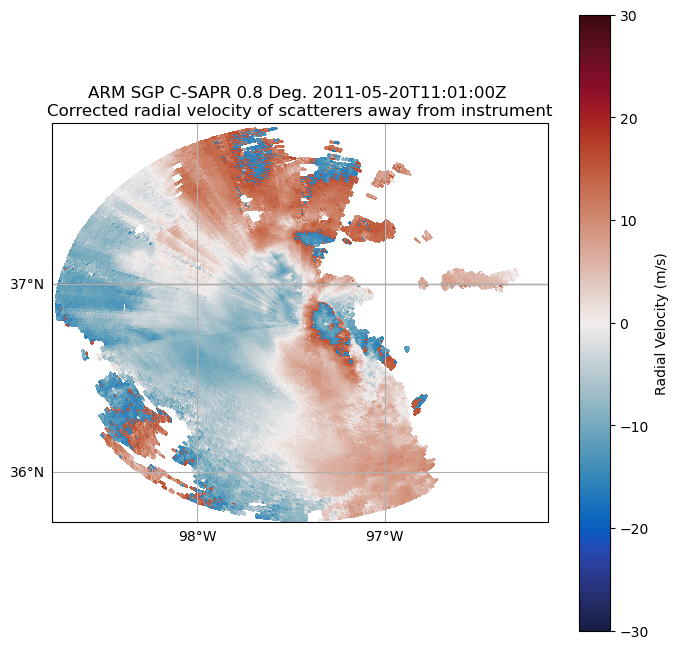

In [24]:
# Plot Dealiased Velocities With Double Nyquist Value
Fig = pyplot.figure(figsize=[8,8])
Display = pyart.graph.RadarMapDisplay(Radar)
Display.plot_ppi_map('corrected_velocity', gatefilter=Gatefilter, sweep=0, resolution='50m', vmin=-30, vmax=30, \
projection=ccrs.PlateCarree(), colorbar_label='Radial Velocity (m/s)', cmap='pyart_balance')
#
# Savefig
Fig.savefig(Output_Diri+'Q4.png', bbox_inches='tight')
pyplot.show()